[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/api_guides/analytics_api/quickstart/03_visualizing_raster_results.ipynb)

###  Planet Analytics API Tutorial Part 3

# Visualizing Raster Results
This notebook shows how to download and visualize [raster results](https://developers.planet.com/docs/analytics/#raster-results) from a Planet Analytics [Subscription](https://developers.planet.com/docs/analytics/#subscriptions).

## Setup 

#### Import Packages

In [2]:
import os
import requests
import pandas as pd
import json
from pprint import pprint
import os
import pathlib
import shutil

from IPython.display import FileLink
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
from rasterio.plot import show_hist
from ipyleaflet import Map
from ipyleaflet import GeoJSON
from ipyleaflet import TileLayer

To use this notebook, you need an [API Key](https://developers.planet.com/quickstart/apis/) for a Planet account with access to the [Analytics API](https://developers.planet.com/docs/analytics/) and a subscription to a raster feed (e.g. buildings or roads)
#### API Key and Test Connection
Set `API_KEY` below if it is not already in your notebook as an environment variable.
See the [Analytics API Docs](https://developers.planet.com/docs/analytics/) for more details on authentication.

In [3]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_YOUR_KEY_HERE')

# alternatively, you can just set your API key directly as a string variable:
# API_KEY = "YOUR_PLANET_API_KEY_HERE"

# construct auth tuple for use in the requests library
BASIC_AUTH = (API_KEY, '')
BASE_URL = "https://api.planet.com/analytics/"

subscriptions_list_url = BASE_URL + 'subscriptions' + '?limit=1000'
resp = requests.get(subscriptions_list_url, auth=BASIC_AUTH)
if resp.status_code == 200:
    print('Yay, you can access the Analytics API')
    subscriptions = resp.json()['data']
    print('Available subscriptions:', len(subscriptions))
else:
    print('Something is wrong:', resp.content)

Yay, you can access the Analytics API
Available subscriptions: 562


#### Specify Analytics Subscription of Interest
Below we will list your available subscription ids and some metadata in a dataframe and then select a subscription of interest. Note: this dataframe is only displaying a few of the rows. Change the code below to have max_rows set to the number of rows in the dataframe to see all of them.

In [ ]:
pd.options.display.max_rows = 25
df = pd.DataFrame(subscriptions)
df['start'] = pd.to_datetime(df['startTime']).dt.date
df['end'] = pd.to_datetime(df['endTime']).dt.date
df[['id', 'title', 'description', 'start', 'end']]

Pick a **road or building** subscription from which to pull results, and replace the ID below.

In [ ]:
SUBSCRIPTION_ID = 'SUBSCRIPTION_ID_HERE'  # replace with your subscription ID

## Getting subscription results
Now we will fetch some example results from the API and visualize the road raster

In [ ]:
# Construct the url for the subscription's results collection
subscription_results_url = BASE_URL + 'collections/' + SUBSCRIPTION_ID + '/items' + '?limit=5'
print("Request URL: {}".format(subscription_results_url))

# Get subscription results collection
resp = requests.get(subscription_results_url, auth=BASIC_AUTH)
if resp.status_code == 200:
    print('Yay, you can access analytic feed results!')
    subscription_results = resp.json()
    print('Fetched {} results.'.format(len(subscription_results['features'])))
else:
    print('Something is wrong:', resp.content)

`subscription_results` is now a geojson feature collection. If we look at the keys of the most recent feature, we will see `links`, which will tell us how to get both geotiffs and webtiles associated with this result.

In [7]:
latest_result = subscription_results['features'][0]
print(latest_result.keys())

dict_keys(['created', 'geometry', 'id', 'links', 'properties', 'type'])


Let's look at one of the links.

In [ ]:
pprint(latest_result['links'][0])

Each link has `rel` and `href` keys. Let's print out the `rel`s for all of the links in our `latest_result`

In [9]:
for link in latest_result['links']:
    print(link['rel'])

self
source-quad
source-tiles
target-quad
target-tiles


#### What are all of these links?
**self:** this is a link to the result geojson we're currently looking at, i.e. `latest_result`

**source-quad:** the input mosaic quad that was used to produce the road raster

**target-quad:** the output mosaic quad (a road raster)

**source-tiles:** web map tiles for the input imagery

**target-tiles:** web map tiles for the analytics output

## Downloading Source and Target Imagery
In this section, we weill use the feature `links` to download source and target GeoTIFF files.

To start, we'll make a helper function to get a url of interest from one of our result features

In [10]:
def get_url(feature, rel):
    """Get the url for a link with the specified rel from a geojson feature
    Args:
        feature - geojson feature from the analytics api
        rel - link relationship of interest
    Returns:
        url - a url for webtiles or geotiff download
    """
    for link in feature['links']:
        if link['rel'] == rel:
            return link['href']

Let's take a look at the download url for the target, specified by the `rel` of `target-quad`

In [ ]:
target_quad_url = get_url(latest_result, rel='target-quad')
print(target_quad_url)

Now, we'll make some functions to download files to a local directory.

In [12]:
# make a local directory in which to save the target quad
data_dir = 'data/'
os.makedirs(data_dir, exist_ok=True)


def download_file(url, dest_path):
    """Download a file hosted at url to the specified local dest_path.
    Args:
        url: url for the file of interest
        dest_path: filepath (can be relative to this notebook)
    """
    # request the image
    resp = requests.get(url, stream=True, auth=BASIC_AUTH)

    # make sure the response is ok
    if resp.status_code == 200:
        # write the image contents to a local file
        with open(dest_path, 'wb') as f:
            resp.raw.decode_content = True
            shutil.copyfileobj(resp.raw, f)
        print('Saved file:', path)
    else:
        print('Something is wrong:', resp.content)


def make_local_path(feature, rel):
    """Programatically generate a local path to store images associated with a feature.
    Args:
        feature - geojson feature with an id
        rel - link relationship of interest
    Returns:
        path - str representing the local path for the (feature, rel) pair
    """
    data_dir = 'data/' + feature['id']
    os.makedirs(data_dir, exist_ok=True)
    return data_dir + '/' + rel + '.tif'


def download(feature, rel):
    """Download store image associated with a (feature, rel) pair.
    Args:
        feature - geojson feature with an id
        rel - link relationship of interest
    Returns:
        path - str representing the local path for the (feature, rel) pair
    """
    path = make_local_path(feature, rel)
    if pathlib.Path(path).exists():
        return path
    url = get_url(feature, rel)
    download_file(url, path)
    return path

You can open the downloaded [GeoTIFF](https://medium.com/planet-stories/a-handy-introduction-to-cloud-optimized-geotiffs-1f2c9e716ec3) file with tools such as [QGIS](https://www.qgis.org/en/site/). Here's a link to your file:

In [13]:
rel = 'target-quad'
path = download(latest_result, 'target-quad')
print('downloaded {} to: {}'.format(rel, path))

FileLink(path)

downloaded target-quad to: data/ea7996c8-9591-4b84-96b0-7b451b2ab2d1/target-quad.tif


/Users/em.steuer/repos/notebooks/jupyter-notebooks/analytics/quickstart/data/ea7996c8-9591-4b84-96b0-7b451b2ab2d1/target-quad.tif

## Rendering source imagery and analytic rasters
In this final part, we will plot source and target images for for one road results feature, inspect the distribution of pixel values, and display the images on a map.

#### Plotting source and target quads
We can use [rasterio](https://rasterio.readthedocs.io/en/stable/) to open and plot these GeoTIFF files.

In [14]:
# make plots show up in this notebook
%matplotlib inline

source:


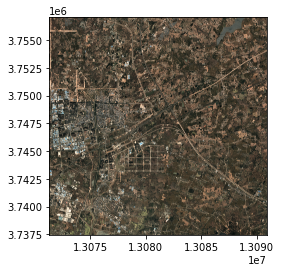

target:


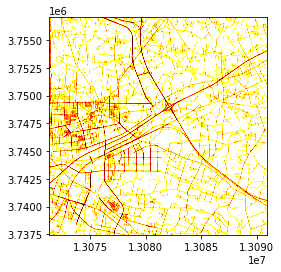

<AxesSubplot:>

In [15]:
source_path = download(latest_result, 'source-quad')
target_path = download(latest_result, 'target-quad')


source_im = rasterio.open(source_path)
target_im = rasterio.open(target_path)
print('source:')
show(source_im)
print('target:')
show(target_im, cmap='hot_r')

The numbers on the axes above are [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) coordinates. We can confirm the coordinate reference system (CRS) with rasterio:

In [16]:
print(source_im.crs)
print(target_im.crs)

LOCAL_CS["WGS 84 / Pseudo-Mercator",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
LOCAL_CS["WGS 84 / Pseudo-Mercator",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


#### Making a bigger plot
The rendered images above are kind of small. We can use matplotlib to make a bigger plot. Here is an example of displaying the target quad on a bigger plot:

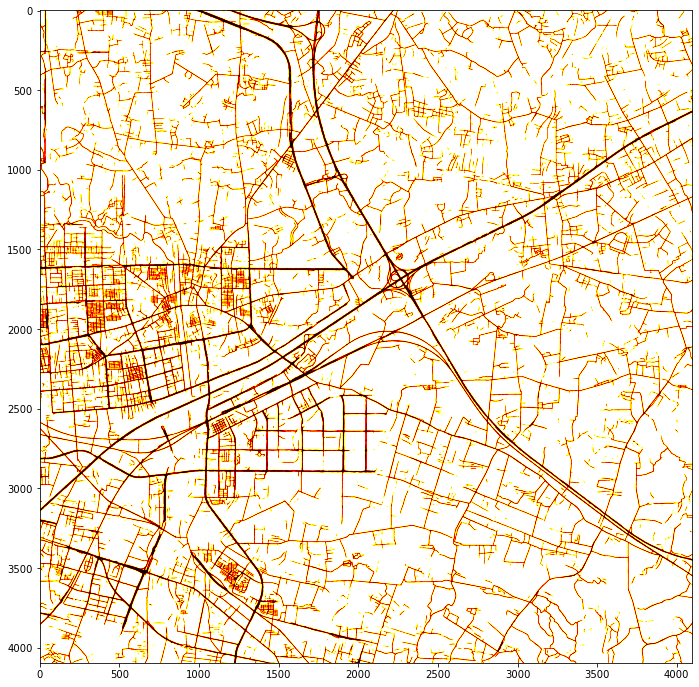

In [17]:
def show_image(feature, rel, cmap=None, size=(10,10)):
    """
    Displays the image of the target quad.

    Args:
        feature (dict): The feature containing the image to display.
        rel (str): The relationship of the image to the feature.
        cmap (str or None): Optional. The colormap to use for image visualization.
                            If None, the default colormap is used.
        size (tuple): Optional. The size of the figure in inches (width, height).

    Returns:
        None. Displays the image using matplotlib.

    Raises:
        FileNotFoundError: If the image file cannot be found.

    """
    source_path = download(feature, rel)
    with rasterio.open(source_path) as ds:
        plt.figure(figsize=size)
        plt.imshow(ds.read(1), cmap=cmap)
        plt.show()

show_image(latest_result, rel='target-quad', cmap='hot_r', size=(12,12))

Unlike the rasterio plot, the pyplot plot did not keep the geo coordinates. The axes now show relative pixel coordinates from 0 to 4096.

#### Inspecting pixel value distributions
Visually it looks like the target quad has just two colors. This is because the road detection raster sets every value in the first band to either 0 or 255. Let's look at the source and target image histograms to see this:

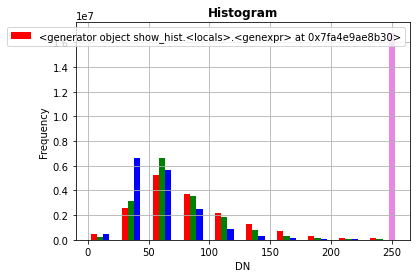

In [18]:
show_hist(source_im)

The source image histogram shows us that the pixel value distribution for red, green, and blue bands. All 3 bands have similarly shaped distributions across the possible values of 0 to 255. (Ignore the 4th band for now). Now let's take a look at the target image:

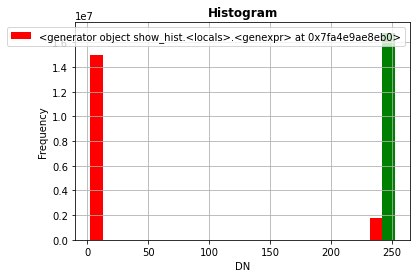

In [19]:
show_hist(target_im)

The road detection histogram looks much different! All of the data is in the first band. (Ignore the 2nd band here.)

Most of the values in the first band are 0 (not road), but some of them are 255 (road)

## Making a map
Since the source and target images are geo-referenced, we can render them on a map! Although we could render the downloaded GeoTIFFs on a map, there is also a tileserver available for both the source and target images. This last step will show how to connect an ipyleaflet map to the tileservers. 

#### Where to look?
Since the `last_result` we looked at before was a geojson feature, we can inspect its geometry to determine where to center our new map.

In [20]:
lon, lat = latest_result['geometry']['coordinates'][0][0]
print(lat, lon)

31.8028925828 117.597656234


#### Starting with an empty basemap
Let's make new map centered around the coordinates we found above.

In [21]:
m = Map(center=(lat, lon), zoom=9)
m

Map(center=[31.8028925828, 117.597656234], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

#### Outlining the feature boundary
We can add a polygon on top of the basemap to show where the `latest_result` imagery was from.

In [22]:
geojson = GeoJSON(data=latest_result, style = {'color': 'blue', 'opacity':1, 'weight':1.9, 'dashArray':'9', 'fillOpacity':0.1})
m.add_layer(geojson)

#### Adding a tileserver
Let's show the target quad on top of the basemap using a `TileLayer`. First we need to get the tileserver url. This is in the `latest_result`'s `links` with a `rel` of `target-tiles`. We can get the url with the `get_url` helper from before.

In [ ]:
target_tile_url = get_url(latest_result, 'target-tiles')
print(target_tile_url)

Now we add a tile layer

In [24]:
target_tile_layer = TileLayer(url=target_tile_url)
m.add_layer(target_tile_layer)
m

Map(center=[31.8028925828, 117.597656234], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

Notice that the results tile layer extends past the blue box for our quad. The tileserver will display all of the results from the same mosaic. This means that results neigboring quads are displayed above. This is a useful way of exploring larger areas at once. There will be unique tileserver urls for different source mosaics (which correspond to points in time, in this case monthly).

#### Mapping analytic results on top of source imagery
We can make a couple of adjustments to get our map to highlight roads on top of source imagery. To do this, we will
- clear the map layers
- add a source imagery `TileLayer`
- add a non-opaque target imagery `TileLayer`

In [25]:
m.clear_layers()
source_tile_url = get_url(latest_result, 'source-tiles')
source_tile_layer = TileLayer(url=source_tile_url)
target_tile_layer = TileLayer(url=target_tile_url, opacity=0.4)
m.add_layer(source_tile_layer)
m.add_layer(target_tile_layer)
m

Map(center=[31.8028925828, 117.597656234], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

Happy mapping!